In [1]:
import numpy as np
from matplotlib import pyplot as plt
from my_utils import *
from sigproc_kit import *

In [2]:
def ion_current(t, Q, P, r0, ra, rb, mu_ion, HV, delay):
    t_ = t - delay
    
    t0 = r0**2 *P *np.log(rb/ra)/(2*mu_ion*HV)
    
    return (t_ > 0) * Q/(2.*np.log(rb/ra)*(t0+t_)  )

In [3]:
def U_parallel_RC(t,I,R,C):
    # calculate time evolution of parallel RC circuit
    # discrete solution of the differential equation
    
    # time step
    dt = t[1]-t[0]
    
    U = np.zeros(len(t))
    last_U = 0
    
    for i in range(len(t)):   
        U[i] = 1/(1/R+C/dt) * ( I[i] + C/dt*last_U) 
        last_U = U[i]
    
    return U

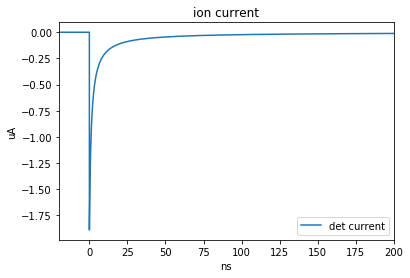

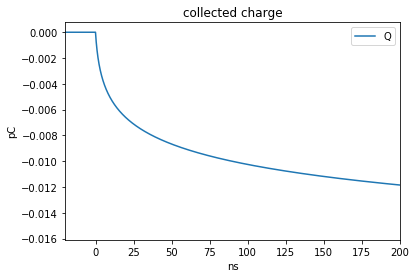

In [4]:
##################################################
##           driftchamber ion current           ##
##################################################


## chamber parameters


# ionization
primary_ions = 1

# gas amplification
G = 1.6e5

# electron charge
e = 1.602e-19


# total charge after gas amplification
Q = -primary_ions * G * e

# gas pressure
P  = 1             # 1 atm = 1 bar

# geometric parameter of idealized proportional counter
# good enough approximation for MDC cell
ra = 10e-6         # 10 um
rb = 2.5e-3        # 2.5 mm
r0 = ra+1e-6       # 1 um over the wire

# argon ion mobility
mu_ion = 1.7*(1e-2)**2 #1.7 cm^2 s^-1 V^-1 atm^-1

# chamber HV (affects only ion drift, not gas gain)
HV = 1600


t = np.linspace(-100e-9,900e-9,100000) # be sure to make not to few steps, if you have a sharp IR

delay = 0e-9 

I = ion_current(t, Q, P, r0, ra, rb, mu_ion, HV, delay)


plt.title("ion current")
plt.plot(t*1e9,I*1e6,label="det current")
plt.xlabel("ns")
plt.ylabel("uA")
plt.xlim(-20,200)
plt.legend()
plt.show()

Q = integrate_dt(t,I)

plt.title("collected charge")
plt.plot(t*1e9,Q*1e12,label="Q")
plt.xlabel("ns")
plt.ylabel("pC")
plt.xlim(-20,200)
plt.legend()
plt.show()




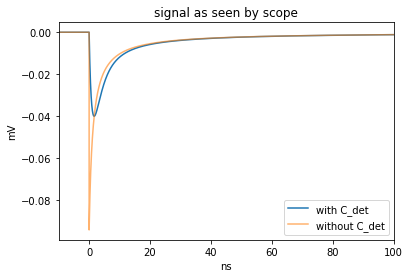

In [5]:
##################################################
##              oscilloscope signal             ##
##################################################

# take in account detector capacitance and
# oscilloscope input load of 50R

#  ion current -------o------o-------- output voltage
#                     |      |
#                    _|_    [ ]
#         C = C_det  ___    [ ]  R = 50R     
#                     |     [ ] 
#                     |      |
#                    GND    GND

# detector and cable capacitance (lumped circuit model)
C = 25e-12

# resistive load of the oscilloscope input
R = 50

U = U_parallel_RC(t,I,R,C)

# for comparison - signal without detector capacitance
U_noC = I * R

plt.title("signal as seen by scope")
plt.plot(t*1e9,U*1e3,                label="with C_det")
plt.plot(t*1e9,U_noC*1e3, alpha=0.6, label="without C_det")
plt.xlabel("ns")
plt.ylabel("mV")
plt.xlim(-10,100)
plt.legend()
plt.show()

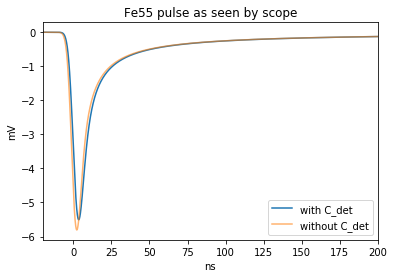

In [6]:
##################################################
##              Fe55 charge cloud               ##
##################################################

primary_ions = 218


# gas amplification
G = 1.6e5

e = 1.602e-19

Q = -primary_ions * G * e

I = ion_current(t, Q, P, r0, ra, rb, mu_ion, HV, delay)



# arrival time smearing due to diffusion/drift
# smearing is almost gaussian
# sigma is estimated by a GARFIELD simulation
# and cross-checked with empirical measurements in the lab
sigma_T = 2.7e-9
# smear current out, due to diffusion
I = fft_gauss_LPF(t,I,sigma=sigma_T)


U = U_parallel_RC(t,I,R,C)



# for comparison - signal without detector capacitance
U_noC = I * R

plt.title("Fe55 pulse as seen by scope")
plt.plot(t*1e9,U*1e3,                label="with C_det")
plt.plot(t*1e9,U_noC*1e3, alpha=0.6, label="without C_det")
plt.xlabel("ns")
plt.ylabel("mV")
plt.xlim(-20,200)
plt.legend()
plt.show()
